# GTEx v6p hg38 expression quantification, 2017 pipeline (Codename Silver)

## 1. STAR first pass alignment

### Download the most up-to-date genome and annotation files for mapping

We're going to use Gencode v.26 and genome GRCh38.10 for our mapping pipeline

In [ ]:
%%bash

cd /tigress/BEE/gtex/external_sources/hg38_silver
# GENCODE v.26
wget ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_26/gencode.v26.annotation.gtf.gz
gunzip gencode.v26.annotation.gtf.gz
# GENOME GRCh38 patch 10
wget ftp://ftp.ensembl.org/pub/release-88/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
gunzip Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz

### Generate STAR genome from hg38 and GENCODE v.26 annotation

Refer to: <code>
https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/processing/silver/STAR_1pass_genomeGenerate_silver.slurm
</code>

In particular, we use the parameter set:
<code>
--runMode genomeGenerate \
--sjdbGTFfile /tigress/BEE/gtex/external_sources/hg38_silver/gencode.v26.annotation.mod.gtf \
--sjdbOverhang 75 \
--genomeDir $STAR_genomeDir \
--genomeFastaFiles /tigress/BEE/gtex/external_sources/hg38_silver/Homo_sapiens.GRCh38.dna.primary_assembly.fa \
--runThreadN 32
</code>

In [ ]:
%%bash

mkdir /tigress/BEE/gtex/results/group_general/joblogs
mkdir /tigress/BEE/gtex/results/group_general/joblogs/STAR_1pass_hg38
chmod -R 775 /tigress/BEE/gtex/results/group_general/joblogs

mkdir /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver
mkdir /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/STAR_1pass_hg38
chmod -R 775 /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver

# I had to adjust the file gencode.v26.annotation.gtf to have chromosome names consistent with the .fa file
# It's saved as gencode.v26.annotation.mod.gtf

cd /tigress/BEE/RNAseq/Scripts/processing/silver/
sbatch STAR_1pass_genomeGenerate_silver.slurm 

The generated STAR 1-pass genome can be found here:

<code>/tigress/BEE/gtex/data/silver/STAR_hg38_1pass/</code>

### STAR 1-pass using generated genome

Refer to: <code>
https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/processing/silver/STAR_1pass_wrapper_silver.py
</code>

The jobs unzip the fastq files into the scratch directory and perform mapping from there: <code>/scratch/gpfs/$USER/</code>

Therefore, we need to partition the samples into multiple jobs to reduce the file i/o overhead. The two parameters in the following script are the number of samples per job, and the number of batches the jobs are organized into:

In [ ]:
%%bash

python /tigress/BEE/RNAseq/Scripts/processing/silver/STAR_1pass_wrapper_silver.py 10 8

Now we run the following files:
<code>
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_1.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_2.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_3.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_4.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_5.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_6.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_7.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_1pass_wrapper_8.sh
</code>

The STAR 1-pass SJ files can be found here:

<code>/tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/STAR_1pass_hg38/</code>

### Obtain the novel sequence junctions, and re-generate the STAR genome for 2nd pass

From the SJ.out.tab files that have the non-canonical splice junctions, we can accumulate the novel sequence junctions that have been found in >1% of the samples (we can also tweak this percentage to be more conservative/permissive).

In [ ]:
%%bash

sbatch /tigress/BEE/RNAseq/Scripts/processing/silver/STAR_novel_sjdb_wrapper_silver.slurm

# parameters
# /tigress/BEE/RNAseq/Scripts/processing/silver/STAR_novel_sjdb_silver.py \
# /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/STAR_1pass_hg38/ \
# /tigress/BEE/gtex/data/silver/STAR_hg38_1pass/STAR_1pass_sjdb.p \
# /tigress/BEE/gtex/data/silver/STAR_hg38_1pass/Number_of_splice_sites_by_number_of_samples_hg19.png \
# /tigress/BEE/gtex/data/silver/STAR_hg38_1pass/SJ.out.tab.Pass1.one.percent.sjdb &

Running this script compiles the list of finished STAR 1-pass samples:
<code>/tigress/BEE/RNAseq/Scripts/processing/silver/checkpoints/STAR_1pass_hg38_samples.txt</code>

As of now, there are <b>7336</b> completed samples.

After the outputting the novel sequence junctions to the file:
<code>/tigress/BEE/gtex/data/silver/STAR_hg38_1pass/SJ.out.tab.Pass1.one.percent.sjdb</code>

we can re-run the STAR genome generator again with an additional parameter:
<code>
--sjdbFileChrStartEnd /tigress/BEE/gtex/data/silver/STAR_hg38_1pass/SJ.out.tab.Pass1.one.percent.sjdb
</code>

And output to the following directory:
<code>/tigress/BEE/gtex/data/silver/STAR_hg38_2pass/</code>

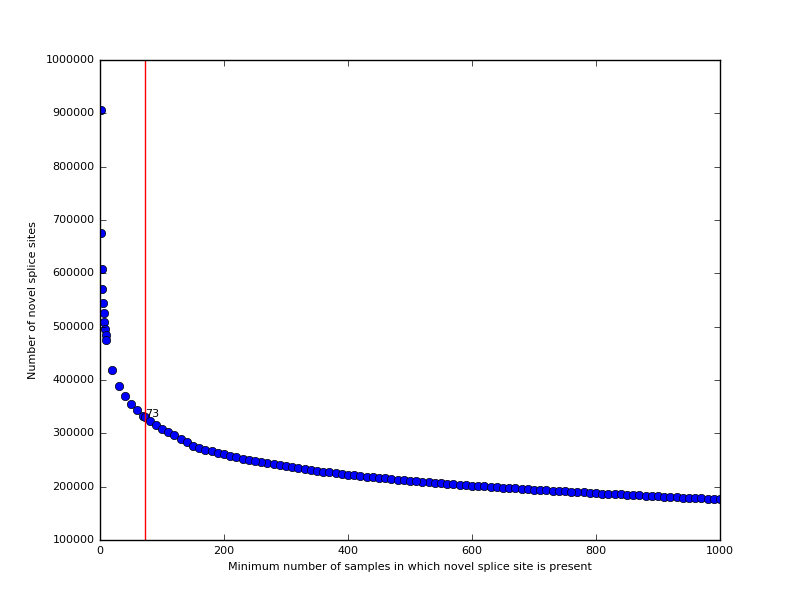

In [3]:
from IPython.display import Image
# This part will depend on where the code is being run - the following code uses relative addresses
import os
proj = os.environ['proj']
Image(filename=proj+'/Analysis/auxiliary/expression/Number_of_splice_sites_by_number_of_samples_hg38.png', width = 600) 

At the threshold of 1% of samples, we get <b>329878</b> novel splice junctions. Now we can generate the STAR genome for the 2nd pass:

In [ ]:
%%bash

sbatch /tigress/BEE/RNAseq/Scripts/processing/silver/STAR_2pass_genomeGenerate_silver.slurm 

The generated STAR 2-pass genome can be found here:
<code>
/tigress/BEE/gtex/data/silver/STAR_hg38_2pass/
</code>

### STAR 2-pass using generated genome

For the second pass, we output the transcriptome alingment files for each sample, as well as the unmapped reads, for downstream analysis.

The jobs unzip the fastq files into the scratch directory and perform mapping from there: <code>/scratch/gpfs/$USER/</code>

Therefore, we need to partition the samples into multiple jobs to reduce the file i/o overhead. The two parameters in the following script are the number of samples per job, and the number of batches the jobs are organized into.

We have the following parameter set for the 2-pass run:
<code>
--genomeLoad LoadAndKeep \
--genomeDir $STAR_genomeDir \
--readFilesIn /scratch/gpfs/${USER}/${SAMPLE}_1.fastq /scratch/gpfs/${USER}/${SAMPLE}_2.fastq \
--outSAMattributes NH HI AS NM MD \
--outFilterMismatchNoverReadLmax 0.04 \
--sjdbScore 1 \
<b>ENCODE standard options</b>
--outFilterType BySJout \
--alignIntronMin 20 \
--alignIntronMax 1000000 \
--alignMatesGapMax 1000000 \
--alignSJoverhangMin 8 \
--alignSJDBoverhangMin 1 \
--outFilterMultimapNmax 20 \
--outFilterMismatchNmax 999 \
<b>needed for RSEM</b>
--quantMode TranscriptomeSAM \
<b>needed for rop</b>
--outReadsUnmapped Fastx
</code>

In [ ]:
%%bash

mkdir /tigress/BEE/gtex/results/group_general/joblogs/STAR_2pass_hg38
chmod -R 775 /tigress/BEE/gtex/results/group_general/joblogs/STAR_2pass_hg38
mkdir /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/STAR_2pass_hg38
chmod -R 775 /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/STAR_2pass_hg38

python /tigress/BEE/RNAseq/Scripts/processing/silver/STAR_2pass_wrapper_silver.py 10 8
chmod a+x /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_*

<code>
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_1.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_2.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_3.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_4.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_5.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_6.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_7.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/STAR_2pass_wrapper_8.sh
</code>

The STAR 2-pass transcriptome alignment files can be found here - we only need the transcriptome alingments for RSEM:

<code>/tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/STAR_2pass_hg38/</code>

### Pseudo-alignment quantification with kallisto

We also obtain the set of pseudo-aligned quantification estimates, along with bootstraps, using kallisto.

First, we want to download the latest human transcriptome fasta files from:

http://ftp.ensembl.org/pub/release-89/fasta/homo_sapiens/

And build the index (todo - how to incorporate the novel splice junctions into this index?)

I have downloaded and deposited the latest kallisto (v 0.43 as of this writing) at:
<code>/tigress/BEE/bin/kallisto</code>

The transcriptome fasta file used was made by combining the cdna and ncrna files:

<code>Homo_sapiens.GRCh38.cdna.all.fa.gz, Homo_sapiens.GRCh38.ncrna.fa.gz</code>

And I named it:

<code>Homo_sapiens.GRCh38.cdna.ncrna.fa.gz</code>

Therefore, the script used for generating the index is:

In [ ]:
%%bash

/tigress/BEE/bin/kallisto index -i /tigress/BEE/gtex/data/silver/kallisto/GRCh38_combined_transcripts.idx \
/tigress/BEE/gtex/data/silver/kallisto/Homo_sapiens.GRCh38.cdna.ncrna.fa.gz

With this index, we can write a wrapper script to obtain the pseudo-alignment quantifications and the bootstrap samples:

In [ ]:
%%bash

mkdir /tigress/BEE/gtex/results/group_general/joblogs/kallisto_hg38
chmod -R 775 /tigress/BEE/gtex/results/group_general/joblogs/kallisto_hg38
mkdir /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/kallisto_hg38
chmod -R 775 /tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/kallisto_hg38

python /tigress/BEE/RNAseq/Scripts/processing/silver/kallisto_wrapper_silver.py 10 8
chmod a+x /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_*

<code>
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_1.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_2.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_3.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_4.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_5.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_6.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_7.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/kallisto_wrapper_8.sh
</code>

The kallisto pseudo-alignment files can be found here:
<code>/tigress/BEE/gtex/data/phenotype/expression/mapped_rna_seq_reads/silver/kallisto_hg38/</code>

Since a lot of jobs didn't finish in time (24 hours sometimes insufficient for 10 samples), we have to check whether the h5 files are valid, and set job the re-run jobs.

Refer to: <code>
https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/processing/silver/kallisto_check_finished_silver.py
</code>

### Expression quantification using RSEM

Now that we have the transcriptome mapping files (in BAM format), we can quantify the expression values using RSEM, both at gene and isoform level. We can also obtain other useful information such as 95% confidence interval using the Bayesian model, as well as the visualization of expression (in formats such as WIG).

We first need to generate the transcriptome reference for RSEM. Using the newst version, RSEM 1.3.0, we can run the following script to generate the genome:

In [ ]:
%%bash

/tigress/BEE/bin/RSEM-1.3.0/rsem-prepare-reference \
--gtf /tigress/BEE/gtex/external_sources/hg38_silver/gencode.v26.annotation.mod.gtf \
/tigress/BEE/gtex/external_sources/hg38_silver/Homo_sapiens.GRCh38.dna.primary_assembly.fa \
/tigress/BEE/gtex/data/silver/RSEM_hg38

After the RSEM reference has been generated, we can set up the RSEM jobs to quantify the isoform expression levels in each sample:

In [ ]:
%%bash

mkdir /tigress/BEE/gtex/results/group_general/joblogs/RSEM_hg38
chmod -R 775 /tigress/BEE/gtex/results/group_general/joblogs/RSEM_hg38
mkdir /tigress/BEE/gtex/data/phenotype/expression/quantified_rna_seq_reads/silver/RSEM_hg38
chmod -R 775 /tigress/BEE/gtex/data/phenotype/expression/quantified_rna_seq_reads/silver/RSEM_hg38

python /tigress/BEE/RNAseq/Scripts/processing/silver/RSEM_wrapper_silver.py 10 8
chmod a+x /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_*

<code>
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_1.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_2.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_3.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_4.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_5.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_6.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_7.sh
sh /tigress/BEE/RNAseq/Scripts/processing/silver/batch/RSEM_wrapper_8.sh
</code>

The kallisto pseudo-alignment files can be found here:
<code>/tigress/BEE/gtex/data/phenotype/expression/quantified_rna_seq_reads/silver/RSEM_hg38/</code>
